In [23]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import healpy as hp

import camb
from camb import model, initialpower

from numpy import linalg as LA
import utils
from utils import m_l as m_l
from utils import bin_l as bin_l

plt.rcParams['figure.figsize'] = (10.0, 8.0)

# functions

In [2]:
def deconv(maps, beam_in, beam_out, lmax):
    ''' 
    Beam in unit of arc-miniute.
    This function changes the value of the input map itself.
    
    '''
    
    _maps = np.copy(maps)
    for j in range(1,3): ### only for Q\U;
        _maps[j] = hp.sphtfunc.decovlving(_maps[j], fwhm = beam_in/60/180*np.pi, lmax = lmax, verbose = False)
        _maps[j] = hp.smoothing(_maps[j], fwhm = beam_out/60/180*np.pi, lmax = lmax, verbose = False)
    return _maps


def smooth(maps, beam_out, lmax):
    _maps = np.copy(maps);
    for j in range(1,3):                        ###for Q and U. Exclude I.
        _maps[j] = hp.smoothing(_maps[j], fwhm = beam_out/60/180*np.pi, lmax = lmax, verbose = False)
    return _maps

# ali_ma = hp.ud_grade(hp.read_map('/smc/jianyao/Ali_maps/Ali_mask_1024.fits'), nside_out = 512)#, verbose=False)
ali_ma = hp.ud_grade(hp.read_map('/smc/jianyao/Ali_maps/ali_mask_wo_edge.fits'), nside_out = 512)
def Mask(maps): 
    maps_ma = hp.ma(maps)
    maps_ma.mask = np.logical_not(ali_ma)
    return maps_ma

def Power_spectrum(maps,R, lmax):
    ''' 
    revised for upper-triangle of the matrix.
    Input:
    maps with multi-frequencies IQU sky maps. 
    Galactic plane cut for calculating the power spectrum.
    lmax.  

    Return: EE and BB cross power spectrum. 
    Shape (2, lmax, nf, nf)
    '''
    n_f = len(maps)
    cl = np.ones((2, n_f*n_f, lmax +1)); Cl = np.zeros((2, lmax+1, n_f, n_f))
    k = 0
    for i in range(n_f):
        for j in range(n_f):
            
            if i >= j :
                cross_ps = hp.anafast(maps[i], maps[j], lmax = lmax, gal_cut=R, nspec=3) ## TT, EE, BB
            else:
                cross_ps = np.zeros((3, lmax+1)) 
            cl[0][k] = cross_ps[1]; cl[1][k] = cross_ps[2]  ## calculate the E and B_mode power spectrum 
            k += 1
            
    for l in range(lmax+1):
        Cl[0, l, : , :] = cl[0, :,l].reshape(n_f, n_f); Cl[1, l, : , :] = cl[1, :,l].reshape(n_f, n_f)
        Cl[0, l] += Cl[0, l].T - np.diag(Cl[0, l].diagonal()) ; Cl[1, l] += Cl[1, l].T - np.diag(Cl[1, l].diagonal()) 
    return Cl

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


# Public area

In [3]:
nside = 512; Nf = 3; lmax = 1000; Q = lmax 

In [4]:
Ell = utils.get_ell(lmax, Q)
el2 = utils.l2(Ell)

In [21]:
cmb_ma = Mask(smooth((cmb_i), beam_out=19, lmax = 1500))
cmb_cls = hp.anafast(cmb_ma, lmax = lmax, nspec = 3)
clee_clean = utils.bin_l(cmb_cls[1], lmax, Q); clbb_clean = utils.bin_l(cmb_cls[2], lmax, Q)

In [8]:
cl_clean = np.ones((2, Q))
cl_clean[0]  = utils.bin_l(cmb_cls[1], lmax, Q); cl_clean[1] = utils.bin_l(cmb_cls[2], lmax, Q)

# CMB should beamed first, and foreground should downgrade to the same resolution

In [6]:
cmb_i = hp.ud_grade(hp.read_map('/fnx/jianyao/cmb_0.05_realizations/cmb_IQU_1.fits', field = None), nside_out = 512)

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [9]:
fore95 = hp.ud_grade(hp.read_map('/fnx/jianyao/1205_observations_AliCPT/95GHz/group2_map_95GHz.fits', field = None, verbose = False), nside_out=512)  ### 19 arcmin, uK_CMB
### 11 arcmin, uK_CMB
fore150 = hp.ud_grade(hp.read_map('/fnx/jianyao/1205_observations_AliCPT/150GHz/group2_map_150GHz.fits', field = None, verbose = False), nside_out=512) 
 ###4.944 arcmin, K_CMB
fore353 = hp.ud_grade(hp.read_map('/fnx/jianyao/1205_observations_HFI_353/group2_map_detector_F353.fits', field = None, verbose = False), nside_out=512)*1e6

In [10]:
noise_95_i = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/95GHz/noise_realizations_95GHz_1.fits', field = None, verbose = False),nside_out = 512)
noise_150_i = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/150GHz/noise_realizations_150GHz_1.fits', field = None, verbose = False),nside_out = 512)
noise_353_i = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/353GHZ_PLA/noise_353_full_map_mc_00001.fits', field = None, verbose = False),nside_out = 512)*1e6

In [11]:
total = np.zeros((Nf, 3, 12*nside**2))
total[0] = smooth(cmb_i, beam_out=19, lmax = 1500) + fore95 + noise_95_i
total[1] = deconv(smooth(cmb_i, beam_out=11, lmax = 1500) + fore150 + noise_150_i, beam_in = 11, beam_out = 19, lmax = 1500)
total[2] = deconv(smooth(cmb_i, beam_out=4.944, lmax = 1500) + fore353 + noise_353_i, beam_in = 4.944, beam_out = 19, lmax = 1500)
total_mask = Mask(total)

In [12]:
Noise = np.zeros((Nf,3,12*nside**2))
Noise[0] = noise_95_i;  
Noise[1] = deconv(noise_150_i, beam_in = 11, beam_out = 19, lmax = 1500) ; 
Noise[2] = deconv(noise_353_i, beam_in = 4.944, beam_out = 19, lmax = 1500)
noise_mask = Mask(Noise)

In [13]:
total_ps_i = Power_spectrum(total_mask, 0, lmax = lmax)
noise_ps_i = Power_spectrum(noise_mask, 0, lmax = lmax)

# ILC in harmonic space

In [50]:
SamNum = 1 ## just one realization , or all the realizations.
Cl_ilc = np.zeros((SamNum, Q)); itera = 1; mode = 0
for n in range(SamNum): ##　SamNu
    
    e = np.matrix(np.ones(Nf))
    total_ps_i_80 = np.load('/fnx/jianyao/ancillary_data/total_ps/total_ps_deconv_masked_EB_%s.npy'%80)
    noise_ps_i_80 = np.load('/fnx/jianyao/ancillary_data/noise_ps/nl_deconv_masked_EB_%s.npy'%80)
    ## Power_spectrum return EE and BB at the same time. So total_ps[0] = EE; total_ps[1] = BB
    noise_bin = utils.bin_l(noise_ps_i[mode], lmax, Q); 
    noise_ilc = np.zeros(Q); 
    total_bin = utils.bin_l(total_ps_i[mode], lmax, Q)

    for r in range(itera):
        if r == 0:
            nuisance = noise_bin
            
        else:
            nuisance = total_bin - All_matrix(Cl_ilc[n], Nf)
            
        #calculate the weight
        W = np.matrix(np.zeros((Q, Nf)))
        noise_clean = np.zeros(Q)                                 ## to get the std of ILC CMB
        for l in range(Q):
            norm = e*np.linalg.pinv((total_bin[l]))*e.T
            noise_clean[l] = e*np.linalg.pinv(noise_bin[l])*e.T   ## to get the std of ILC CMB
            W[l,:] = e*np.linalg.pinv((total_bin[l]))/norm   

        for i in range(Q):
            
            ''' whether include noise_bin or not;  WNW = 1/(eN{-1}e.T)'''
            
            noise_ilc[i] = W[i,:]*(nuisance[i])*np.transpose(W[i,:])     #noise_bin　nuisance[i]
            Cl_ilc[n, i] = 1.0/(e*np.linalg.pinv((total_bin[i]))*e.T) - noise_ilc[i]
            
cl_ilc_mean = np.mean(Cl_ilc, axis = 0)
cl_ilc_std = np.std(Cl_ilc, axis = 0)

/home/jianyao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/home/jianyao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide


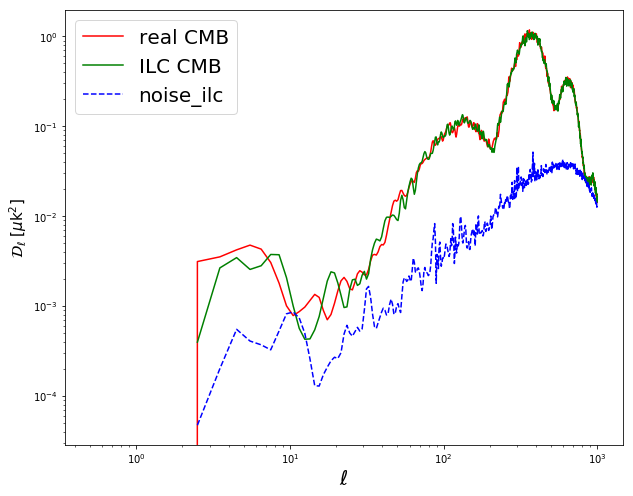

In [51]:
fig1 = plt.figure(1, figsize=(10,8))
# plt.axis('off')
# frame1=fig1.add_axes((.1,.4,.8,.5)) # x0, y0, width, height
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*cl_clean[mode], 'r-',label = 'real CMB')
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*(cl_ilc_mean), 'g-', label = 'ILC CMB')
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*noise_ilc, 'b--', label = 'noise_ilc')
# plt.xscale('linear')
# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*cl_extra, 'b-',label = 'extra CMB')
# plt.errorbar(Ell,Ell*(Ell+1)*cl_ilc/2/np.pi, yerr = std_ilc,fmt='-o',capthick = 0.1)
# plt.ylim(1e-4, 1e-1)
plt.xlabel('$\ell$', fontsize = 20); 
plt.ylabel(r'$\mathcal{D}_{\ell}$ [$\mu$k$^2$]', fontsize = 15)
plt.legend(fontsize = 20)
# plt.title('ILC in harmonical space, subtracting %s * dust'%frac, fontsize = 20)

# frame2=fig1.add_axes((.1,.1,.8,.3))
# plt.semilogx(Ell, (cl_ilc - cls)/cls*100, 'k--')
# plt.axhline(0,color = 'k')
# plt.ylabel(r'$\Delta \mathcal{D}_\ell$/$\mathcal{D}^{real}_{\ell} $ [%]', fontsize = 15);plt.xlabel(r'$\ell$', fontsize = 20)
# plt.ylim(-100, 100)
# plt.savefig('/home/jianyao/Ali_maps/results/0212/ILC_BB_1_bin_1000.jpg', format = 'png')

# ILC cleand maps

In [38]:
m_num = int((1 + lmax)*(lmax+1 -1)/2) # the number of alm of lmax=l for m >= 0; m = 0,1 for l = 1; m = 0,1,2 for l = 2.
alm_Q = np.zeros((Nf, m_num), dtype = 'complex128'); alm_U = np.zeros((Nf, m_num), dtype = 'complex128')

for i in range(Nf):
    alm_Q[i] = hp.map2alm(total_mask[i], lmax = lmax-1)[1]; # 95GHz, 150GHz, 353GHz
    alm_U[i] = hp.map2alm(total_mask[i], lmax = lmax-1)[2]; 

In [39]:
alm_Q_clean = np.zeros(m_num,dtype = 'complex128'); alm_U_clean = np.zeros(m_num, dtype = 'complex128')

for l in np.arange(lmax):
    alm_Q_clean[m_l(lmax - 1, l)] = np.dot(np.array(W[l, :]),alm_Q[:,m_l(lmax - 1, l)])[0] #np.dot(np.array(weight[l, :]),alm_Q[:,m_l(lmax, l)])[0]#
    alm_U_clean[m_l(lmax - 1, l)] = np.dot(np.array(W[l, :]),alm_U[:,m_l(lmax - 1, l)])[0]
    
alm_Q_clean[m_l(lmax, 0)] = 0; alm_Q_clean[m_l(lmax, 1)] = 0
alm_U_clean[m_l(lmax, 0)] = 0; alm_U_clean[m_l(lmax, 1)] = 0

In [40]:
# Q_clean = hp.alm2map(alm_Q_clean, nside = nside, lmax = lmax - 1); U_clean = hp.alm2map(alm_U_clean, nside = nside, lmax = lmax - 1);
# I_clean = np.zeros_like(Q_clean)
almT = np.zeros_like(alm_Q_clean)
cmb_clean = hp.alm2map(np.row_stack((almT, alm_Q_clean, alm_U_clean)), nside = nside, lmax = lmax - 1)
# alm_total = hp.map2alm(cmb_clean)
# B_maps = hp.alm2map(alm_total[2], nside = nside, verbose = False)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [41]:
cls_final = hp.anafast(Mask(cmb_clean), nspec=3, lmax = lmax)
# cls_final = hp.alm2cl(alm_U_clean)

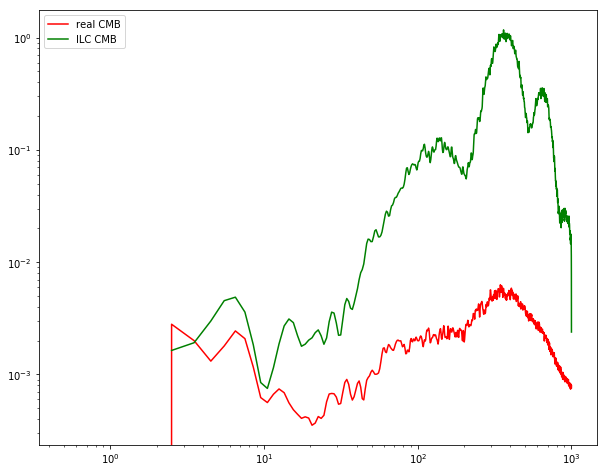

In [44]:
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*clbb_clean, 'r-',label = 'real CMB')
plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*(cls_final[1][:lmax] - noise_ilc), 'g-', label = 'ILC CMB')
# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*noise_ilc, 'b--', label = 'noise_ilc')
# plt.loglog(Ell, Ell*(Ell+1)/2/np.pi*total_cl[2], 'k--', label = 'total_ps')

plt.legend()

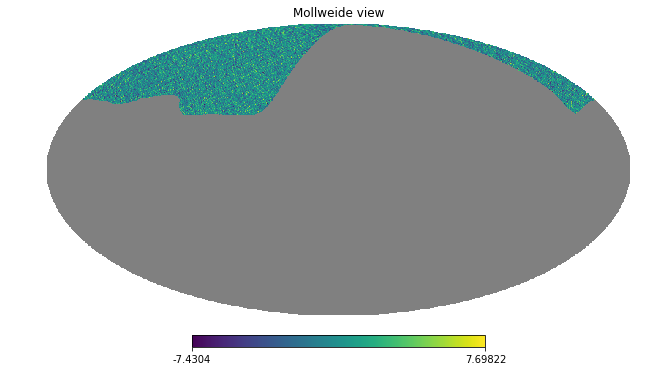

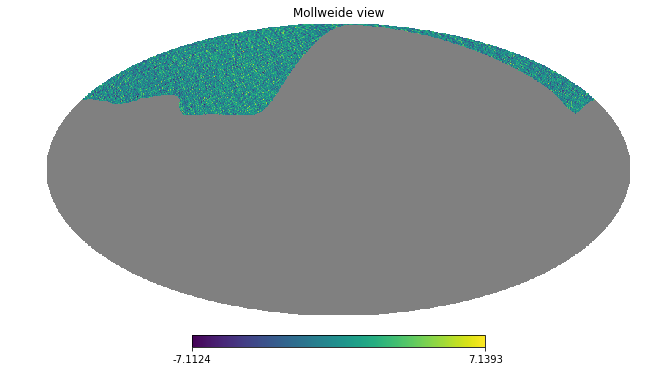

In [26]:
hp.mollview(Mask(cmb_clean[2])); hp.mollview(cmb_ma[2])

In [28]:
np.linalg.norm((cmb_clean[2], cmb_ma[2]))

3337.8894244070575

In [294]:
total_cl = hp.anafast(total_mask[1], nspec=3, lmax = lmax - 1)

In [ ]:
# COMPONENT GROUP 1: cmb                                                                                                                                                                                                                     
# COMPONENT GROUP 2: synchrotron freefree thermaldust spindust co
# COMPONENT GROUP 3: faintradiops faintirps thermalsz firb
# COMPONENT GROUP 4: strongirps strongradiops

# Writing into fits file

In [30]:
names = ['Q_polarization', 'U_polarization']

In [33]:
hp.write_map('/fnx/jianyao/HS_clean_CMB/Cleaned_QU_%03d.fits'%(1),cmb_clean[1:], coord='G', column_names= names, column_units='uK_CMB')

In [34]:
clean_test = hp.read_map('/fnx/jianyao/HS_clean_CMB/Cleaned_QU_%03d.fits'%(1), h = True, field = None)

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [35]:
clean_test[1]

[('XTENSION', 'BINTABLE'),
 ('BITPIX', 8),
 ('NAXIS', 2),
 ('NAXIS1', 8192),
 ('NAXIS2', 3072),
 ('PCOUNT', 0),
 ('GCOUNT', 1),
 ('TFIELDS', 2),
 ('TTYPE1', 'Q_polarization'),
 ('TFORM1', '1024E'),
 ('TUNIT1', 'uK_CMB'),
 ('TTYPE2', 'U_polarization'),
 ('TFORM2', '1024E'),
 ('TUNIT2', 'uK_CMB'),
 ('PIXTYPE', 'HEALPIX'),
 ('ORDERING', 'RING'),
 ('COORDSYS', 'G'),
 ('EXTNAME', 'xtension'),
 ('NSIDE', 512),
 ('FIRSTPIX', 0),
 ('LASTPIX', 3145727),
 ('INDXSCHM', 'IMPLICIT'),
 ('OBJECT', 'FULLSKY')]

In [29]:
cmb_clean[1:].shape

(2, 3145728)

# Calculate the PS of noise and total_ps

In [165]:
SamNum =100

for i in range(78,79):
    if i < 50:
        noise_95 = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/95GHz/noise_realizations_95GHz_%s.fits'%(i), field = None, verbose = False),nside_out = nside)
        noise_150 = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/150GHz/noise_realizations_150GHz_%s.fits'%(i), field = None, verbose = False),nside_out = nside)
    else: 
        noise_95 = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/95GHz/noise_95GHz_%s.fits'%(i), field = None, verbose = False),nside_out = nside)
        noise_150 = hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/150GHz/noise_150GHz_%s.fits'%(i), field = None, verbose = False),nside_out = nside)
        
    noise_353 = 1e6*hp.ud_grade(hp.read_map('/fnx/jianyao/Noise_realizations/353GHZ_PLA/noise_353_full_map_mc_%05d.fits'%i, field = None, verbose = False), nside_out=nside)
    
    Noise = np.zeros((Nf,3,12*nside**2))
    Noise[0] = noise_95;  
    Noise[1] = deconv(noise_150, beam_in = 11, beam_out = 19, lmax = 1500); 
    Noise[2] = deconv(noise_353, beam_in = 4.944, beam_out = 19, lmax = 1500);
    noise_ps_i = utils.Power_spectrum(Mask(Noise), 0, lmax = lmax)
#     np.save('/fnx/jianyao/ancillary_data/noise_ps/nl_deconv_masked_EB_%s.npy'%i, noise_ps_i)
    
    cmb_i = hp.ud_grade(hp.read_map('/fnx/jianyao/cmb_0.05_realizations/cmb_IQU_%s.fits'%(i), field = None, verbose = False), nside_out = 512)
    total = np.zeros((Nf, 3, 12*nside**2))
    total[0] = smooth(cmb_i, beam_out=19, lmax = 1500) + fore95 + noise_95
    total[1] = deconv(smooth(cmb_i, beam_out=11, lmax = 1500) + fore150 + noise_150, beam_in = 11, beam_out = 19, lmax = 1500)
    total[2] = deconv(smooth(cmb_i, beam_out=4.944, lmax = 1500) + fore353 + noise_353, beam_in = 4.944, beam_out = 19, lmax = 1500)
    total_mask = Mask(total)
    
    total_ps_i = utils.Power_spectrum(total_mask, 0, lmax = lmax)
#     np.save('/fnx/jianyao/ancillary_data/total_ps/total_ps_deconv_masked_EB_%s.npy'%i, total_ps_i)

In [164]:
## To generate one realization of noise maps. 

n3test = hp.read_map('/smc/jianyao/Ali_maps/Noise_maps/fits/I_Noise_150_G_1024.fits', partial=True)
n3zeros = n3test*0 #0,0,nan,nan......
nIQU = np.zeros((3, len(n3test)))
index = np.arange(len(n3test))#index[n2zeros == 0]
# for i in index[n2test <= 5]:
SamNum = 50
for n in range(50, 50+SamNum):
    
    for i in index[n3zeros==0]:#[n3zeros==0]:    #full_ali map, without mask out the edge.
        nIQU[0][i] = np.random.normal(0, n3test[i])
        nIQU[1][i] = np.random.normal(0, n3test[i]*np.sqrt(2))
        nIQU[2][i] = np.random.normal(0, n3test[i]*np.sqrt(2))

    hp.write_map('/fnx/jianyao/Noise_realizations/150GHz/noise_150GHz_%s.fits'%(n), nIQU)

NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
